#### Начнем с самого простого подхода, который требует наименьшего количества ресурсов и который создаст нам некий бейзлайн

In [85]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")


data_train = pd.read_csv('data/train_spam.csv')
data_train['target'] = data_train['text_type'].apply(lambda x: 1 if x == 'spam' else 0)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(data_train['text'], data_train['target'], 
                                                    test_size=0.2, random_state=42)

# TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)



# Evaluate different classic machine learning approaches
def evaluate_method(model, model_name, X_train_tfidf, y_train, X_test_tfidf, y_test, verbose=0):
    if model_name == 'Catboost GBM':
        model.fit(X_train_tfidf, y_train, verbose=0)
    else:
        model.fit(X_train_tfidf, y_train)
    try:
        preds = model.predict_proba(X_test_tfidf)[:, 1]
        y_pred = preds > 0.5
    except:
        y_pred = model.predict(X_test_tfidf)
        preds = y_pred
    print(f"{model_name} ROC AUC: {roc_auc_score(y_test, preds):.4f}")
    print(f"{model_name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"{model_name} Classification Report:\n", classification_report(y_test, y_pred))
    print(f"{model_name} Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    return model

# Evaluation
methods = [
        (LogisticRegression(), 'Logistic Regression'),
        (MultinomialNB(), 'Naive Bayes'),
        (LinearSVC(), 'Linear Support Vector Machine'),
        (RandomForestClassifier(), 'Random Forest'),
        (CatBoostClassifier(), 'Catboost GBM')
        ]
models = {}
for model, model_name in methods:
    models[model_name] = evaluate_method(model, model_name, X_train_tfidf, y_train, X_test_tfidf, y_test)

Logistic Regression ROC AUC: 0.9788
Logistic Regression Accuracy: 0.9281
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95      2321
           1       0.92      0.82      0.87       935

    accuracy                           0.93      3256
   macro avg       0.93      0.90      0.91      3256
weighted avg       0.93      0.93      0.93      3256

Logistic Regression Confusion Matrix:
 [[2257   64]
 [ 170  765]]
Naive Bayes ROC AUC: 0.9365
Naive Bayes Accuracy: 0.8566
Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.99      0.91      2321
           1       0.95      0.53      0.68       935

    accuracy                           0.86      3256
   macro avg       0.89      0.76      0.79      3256
weighted avg       0.87      0.86      0.84      3256

Naive Bayes Confusion Matrix:
 [[2293   28]
 [ 439  496]]
Linear Suppo

| Model        | ROC AUC | Примечание |
|--------------|---------|------------|
| LogReg       | 0.9788  ||
| Naive Bayes  | 0.9365  ||
| Linear SVM   | 0.9341  | Не умеет предсказывать вероятности|
| Random Forest| 0.9855  ||
| Catboost     | 0.9808  ||

#### 

#### А еще тут видно, что у нас присутствует дизбаланс классов, а метрика выбрана не такая, которая не подвержена ему.. Лучше было бы использовать PR AUC. 

#### Теперь посмотрим модельки на основе нейросетей, начнем со стандартного берта

#### Для начала посмотрим сколько же токенов мы хотим подавать на вход. Если слишком много, то будет много паддингов, если мало - то будет теряться информация.

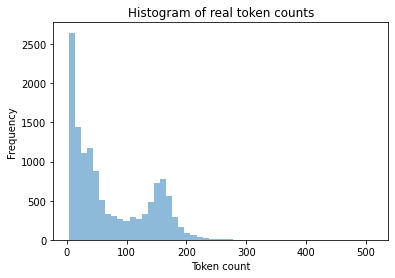

25th percentile (Q1): 17
50th percentile (Q2/Median): 45
75th percentile (Q3): 135
Number of samples below Q1: 3226
Number of samples below Q2/Median: 6471
Number of samples below Q3: 9741
Number of samples below 256: 12994
Number of samples: 13022


In [14]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained(model_name)

texts = list(np.array(X_train))
encodings = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
real_token_counts = torch.sum(encodings['input_ids'] != 0, dim=1).numpy()

plt.hist(real_token_counts, bins=50, alpha=0.5, label='Real token count')
plt.xlabel('Token count')
plt.ylabel('Frequency')
plt.title('Histogram of real token counts')
plt.show()

q25, q50, q75 = np.percentile(real_token_counts, [25, 50, 75])

print(f"25th percentile (Q1): {q25:.0f}")
print(f"50th percentile (Q2/Median): {q50:.0f}")
print(f"75th percentile (Q3): {q75:.0f}")

below_q1 = np.sum(real_token_counts < q25)
below_q2 = np.sum(real_token_counts < q50)
below_q3 = np.sum(real_token_counts < q75)
below_256 = np.sum(real_token_counts < 256)

print(f"Number of samples below Q1: {below_q1}")
print(f"Number of samples below Q2/Median: {below_q2}")
print(f"Number of samples below Q3: {below_q3}")
print(f"Number of samples below 256: {below_256}")
print(f"Number of samples: {len(encodings['input_ids'])}")

#### 256 - не слишком большое число, так что его можно оставить. 512 видно, что слишком избыточно

In [16]:
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
import numpy as np
import torch
from datasets import Dataset

# Loading original BERT
model_name = 'bert-base-uncased'
tokenizer = BertTokenizerFast.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
EPOCH_NUMBER = 5


def generate_dataset(texts, labels, max_length=256):
    encodings = tokenizer(texts, padding=True, truncation=True, 
                          max_length=max_length, return_tensors="pt")
    try:
        dataset = Dataset.from_dict({"input_ids": encodings['input_ids'], 
                                     "attention_mask": encodings['attention_mask'], 
                                     "labels": labels})
    except:
        dataset = Dataset.from_dict({"input_ids": encodings['input_ids'], 
                                     "attention_mask": encodings['attention_mask']})
    return dataset

train_dataset = generate_dataset(list(np.array(X_train)), y_train)
test_dataset = generate_dataset(list(np.array(X_test)), y_test)

# Training Args
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=EPOCH_NUMBER,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch"
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=lambda pred: {
    'ROC AUC': roc_auc_score(y_test, pred.predictions.argmax(-1)), 
    # упс, тут баг, я в ROC AUC подаю предсказанные метки классов, а не вероятности
    },
)


trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/8140 [00:00<?, ?it/s]

Checkpoint destination directory ./results/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'loss': 0.3036, 'learning_rate': 5e-05, 'epoch': 0.31}


Checkpoint destination directory ./results/checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'loss': 0.1929, 'learning_rate': 4.6727748691099475e-05, 'epoch': 0.61}


Checkpoint destination directory ./results/checkpoint-1500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'loss': 0.1693, 'learning_rate': 4.3455497382198955e-05, 'epoch': 0.92}


  0%|          | 0/407 [00:00<?, ?it/s]

{'eval_loss': 0.1364532709121704, 'eval_ROC AUC': 0.9562004207111539, 'eval_runtime': 27.2087, 'eval_samples_per_second': 119.668, 'eval_steps_per_second': 14.958, 'epoch': 1.0}
{'loss': 0.1018, 'learning_rate': 4.018324607329843e-05, 'epoch': 1.23}
{'loss': 0.0929, 'learning_rate': 3.691099476439791e-05, 'epoch': 1.54}
{'loss': 0.0798, 'learning_rate': 3.3638743455497386e-05, 'epoch': 1.84}


  0%|          | 0/407 [00:00<?, ?it/s]

{'eval_loss': 0.12889708578586578, 'eval_ROC AUC': 0.9694122715867907, 'eval_runtime': 27.4139, 'eval_samples_per_second': 118.772, 'eval_steps_per_second': 14.846, 'epoch': 2.0}
{'loss': 0.0689, 'learning_rate': 3.036649214659686e-05, 'epoch': 2.15}
{'loss': 0.041, 'learning_rate': 2.709424083769634e-05, 'epoch': 2.46}
{'loss': 0.035, 'learning_rate': 2.382198952879581e-05, 'epoch': 2.76}


  0%|          | 0/407 [00:00<?, ?it/s]

{'eval_loss': 0.2064673900604248, 'eval_ROC AUC': 0.9674354360443014, 'eval_runtime': 27.4612, 'eval_samples_per_second': 118.567, 'eval_steps_per_second': 14.821, 'epoch': 3.0}
{'loss': 0.0377, 'learning_rate': 2.054973821989529e-05, 'epoch': 3.07}
{'loss': 0.0199, 'learning_rate': 1.7277486910994763e-05, 'epoch': 3.38}
{'loss': 0.0112, 'learning_rate': 1.4005235602094241e-05, 'epoch': 3.69}
{'loss': 0.0155, 'learning_rate': 1.0732984293193717e-05, 'epoch': 3.99}


  0%|          | 0/407 [00:00<?, ?it/s]

{'eval_loss': 0.15138591825962067, 'eval_ROC AUC': 0.9730085916313963, 'eval_runtime': 27.1434, 'eval_samples_per_second': 119.955, 'eval_steps_per_second': 14.994, 'epoch': 4.0}
{'loss': 0.0058, 'learning_rate': 7.4607329842931935e-06, 'epoch': 4.3}
{'loss': 0.0052, 'learning_rate': 4.18848167539267e-06, 'epoch': 4.61}
{'loss': 0.005, 'learning_rate': 9.162303664921465e-07, 'epoch': 4.91}


  0%|          | 0/407 [00:00<?, ?it/s]

{'eval_loss': 0.15517643094062805, 'eval_ROC AUC': 0.9754669640367996, 'eval_runtime': 27.5222, 'eval_samples_per_second': 118.305, 'eval_steps_per_second': 14.788, 'epoch': 5.0}
{'train_runtime': 1890.098, 'train_samples_per_second': 34.448, 'train_steps_per_second': 4.307, 'train_loss': 0.07281432813147874, 'epoch': 5.0}


TrainOutput(global_step=8140, training_loss=0.07281432813147874, metrics={'train_runtime': 1890.098, 'train_samples_per_second': 34.448, 'train_steps_per_second': 4.307, 'train_loss': 0.07281432813147874, 'epoch': 5.0})

#### Достиг 0.975 оригинальным бертом, хотя у меня ROC AUC был сломан.. Я в ROC AUC подаю предсказанные метки классов, а не вероятности. Пофиксил этот баг и сейчас по чекпоинтам провалидирую модель

In [96]:
from torch.utils.data import DataLoader
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

metrics_NN = []
metrics_ensemble = []
preds_NN = []

def predict_with_model(model, test_data_loader):
    predictions = []
    for batch in tqdm(test_data_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = torch.Tensor(batch["attention_mask"]).to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            batch_predictions = torch.nn.functional.softmax(logits, dim=-1)
            predictions.extend(batch_predictions.tolist())
    return predictions

for batch_number in np.arange(500, 8001, 500):
    checkpoint_path = f'./results/checkpoint-{batch_number}/'
    model = BertForSequenceClassification.from_pretrained(checkpoint_path)
    model.to(device)
    model.eval()

    test_data_loader = DataLoader(test_dataset.with_format("torch"), batch_size=16)
    
    predictions = np.array(predict_with_model(model, test_data_loader))[:, 1]
    preds_NN.append(predictions)
    predictions_RF = np.array(models['Random Forest'].predict_proba(X_test_tfidf))[:, 1]
    predictions_catboost = np.array(models['Catboost GBM'].predict_proba(X_test_tfidf))[:, 1]
    predictions_ensemble = predictions * 0.6 + \
                           predictions_RF * 0.3 + \
                           predictions_catboost * 0.1


    roc_auc_NN = roc_auc_score(y_test, predictions)
    roc_auc_ensemble = roc_auc_score(y_test, predictions_ensemble)
    print(f"{batch_number} ROC AUC NN: {roc_auc_NN:.4f}")
    print(f"{batch_number} ROC AUC ensemble: {roc_auc_ensemble:.4f}")

    metrics_NN.append(roc_auc_NN)
    metrics_ensemble.append(roc_auc_ensemble)

100%|██████████| 204/204 [00:25<00:00,  7.88it/s]


500 ROC AUC NN: 0.9821
500 ROC AUC ensemble: 0.9899


100%|██████████| 204/204 [00:26<00:00,  7.83it/s]


1000 ROC AUC NN: 0.9898
1000 ROC AUC ensemble: 0.9917


100%|██████████| 204/204 [00:26<00:00,  7.78it/s]


1500 ROC AUC NN: 0.9902
1500 ROC AUC ensemble: 0.9927


100%|██████████| 204/204 [00:26<00:00,  7.75it/s]


2000 ROC AUC NN: 0.9918
2000 ROC AUC ensemble: 0.9919


100%|██████████| 204/204 [00:26<00:00,  7.73it/s]


2500 ROC AUC NN: 0.9928
2500 ROC AUC ensemble: 0.9921


100%|██████████| 204/204 [00:26<00:00,  7.73it/s]


3000 ROC AUC NN: 0.9937
3000 ROC AUC ensemble: 0.9939


100%|██████████| 204/204 [00:26<00:00,  7.72it/s]


3500 ROC AUC NN: 0.9930
3500 ROC AUC ensemble: 0.9931


100%|██████████| 204/204 [00:26<00:00,  7.62it/s]


4000 ROC AUC NN: 0.9895
4000 ROC AUC ensemble: 0.9925


100%|██████████| 204/204 [00:26<00:00,  7.71it/s]


4500 ROC AUC NN: 0.9928
4500 ROC AUC ensemble: 0.9930


100%|██████████| 204/204 [00:26<00:00,  7.70it/s]


5000 ROC AUC NN: 0.9921
5000 ROC AUC ensemble: 0.9932


100%|██████████| 204/204 [00:26<00:00,  7.69it/s]


5500 ROC AUC NN: 0.9906
5500 ROC AUC ensemble: 0.9927


100%|██████████| 204/204 [00:26<00:00,  7.68it/s]


6000 ROC AUC NN: 0.9929
6000 ROC AUC ensemble: 0.9929


100%|██████████| 204/204 [00:26<00:00,  7.68it/s]


6500 ROC AUC NN: 0.9909
6500 ROC AUC ensemble: 0.9931


100%|██████████| 204/204 [00:26<00:00,  7.67it/s]


7000 ROC AUC NN: 0.9899
7000 ROC AUC ensemble: 0.9930


100%|██████████| 204/204 [00:26<00:00,  7.66it/s]


7500 ROC AUC NN: 0.9930
7500 ROC AUC ensemble: 0.9931


100%|██████████| 204/204 [00:26<00:00,  7.68it/s]


8000 ROC AUC NN: 0.9929
8000 ROC AUC ensemble: 0.9931


In [130]:
from torch.utils.data import DataLoader
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

metrics_NN = []
metrics_ensemble = []

def predict_with_model(model, test_data_loader):
    predictions = []
    for batch in test_data_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = torch.Tensor(batch["attention_mask"]).to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            batch_predictions = torch.nn.functional.softmax(logits, dim=-1)
            predictions.extend(batch_predictions.tolist())
    return predictions


for i, batch_number in enumerate(np.arange(500, 8001, 500)):
    checkpoint_path = f'./results/checkpoint-{batch_number}/'
    model = BertForSequenceClassification.from_pretrained(checkpoint_path)
    model.to(device)
    model.eval()

    test_data_loader = DataLoader(test_dataset.with_format("torch"), batch_size=16)
    
    predictions = np.array(predict_with_model(model, test_data_loader))[:, 1]
    predictions_RF = np.array(models['Random Forest'].predict_proba(X_test_tfidf))[:, 1]
    predictions_catboost = np.array(models['Catboost GBM'].predict_proba(X_test_tfidf))[:, 1]
    predictions_ensemble = predictions * 0.98 + \
                           predictions_RF * 0.01 + \
                           predictions_catboost * 0.01


    roc_auc_NN = roc_auc_score(y_test, predictions)
    roc_auc_ensemble = roc_auc_score(y_test, predictions_ensemble)
    print(f"{batch_number} ROC AUC NN: {roc_auc_NN:.4f}")
    print(f"{batch_number} ROC AUC ensemble: {roc_auc_ensemble:.4f}")

    metrics_NN.append(roc_auc_NN)
    metrics_ensemble.append(roc_auc_ensemble)

500 ROC AUC NN: 0.9821
500 ROC AUC ensemble: 0.9885
1000 ROC AUC NN: 0.9898
1000 ROC AUC ensemble: 0.9924
1500 ROC AUC NN: 0.9902
1500 ROC AUC ensemble: 0.9942
2000 ROC AUC NN: 0.9918
2000 ROC AUC ensemble: 0.9936
2500 ROC AUC NN: 0.9928
2500 ROC AUC ensemble: 0.9936
3000 ROC AUC NN: 0.9937
3000 ROC AUC ensemble: 0.9951
3500 ROC AUC NN: 0.9930
3500 ROC AUC ensemble: 0.9943
4000 ROC AUC NN: 0.9895
4000 ROC AUC ensemble: 0.9935
4500 ROC AUC NN: 0.9928
4500 ROC AUC ensemble: 0.9934
5000 ROC AUC NN: 0.9921
5000 ROC AUC ensemble: 0.9938
5500 ROC AUC NN: 0.9906
5500 ROC AUC ensemble: 0.9932
6000 ROC AUC NN: 0.9929
6000 ROC AUC ensemble: 0.9937
6500 ROC AUC NN: 0.9909
6500 ROC AUC ensemble: 0.9936
7000 ROC AUC NN: 0.9899
7000 ROC AUC ensemble: 0.9933
7500 ROC AUC NN: 0.9930
7500 ROC AUC ensemble: 0.9937
8000 ROC AUC NN: 0.9929
8000 ROC AUC ensemble: 0.9936


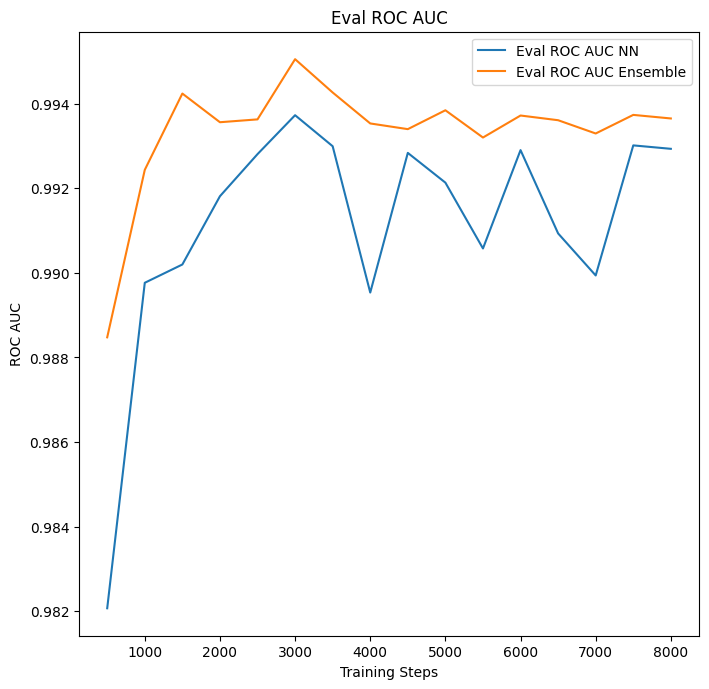

In [124]:
def plot(roc_auc_NN, roc_auc_ensemble):
    plt.figure(figsize=(8, 8), dpi=100)
    plt.plot(np.arange(500, 8001, 500), roc_auc_NN, label='Eval ROC AUC NN')
    plt.plot(np.arange(500, 8001, 500), roc_auc_ensemble, label='Eval ROC AUC Ensemble')
    plt.xlabel('Training Steps')
    plt.ylabel('ROC AUC')
    plt.title('Eval ROC AUC')
    plt.legend()
    plt.show()

plot(metrics_NN, metrics_ensemble)

#### Прекрасно видно, что оригинальный BERT смог получить 0.99+ ROC AUC на детекции спама. А ансамблирование помогает улучшить результат, потому что нейросеть очень любит ударяться в крайности и предсказывать почти метки классов, а не сами вероятности. Поэтому даже добавления хоть немного предсказания классических моделей помогает получать вероятности, которые улучшают результат.
### Что можем еще сделать? 
 * Попробовать использовать более совершенные берты, а не 7семилетней давности: RoBERTa, DistilBERT, DeBERTa; либо просто маленькие версии SOTA моделек: https://paperswithcode.com/task/text-classification.
 * Если хотим уменьшить количество потребляемых ресурсов модели, то можно взять более мелкий BERT (и более современный) и попробовать обучить его
 * Если хотим повысить надежность, то можно взять ансамбль моделей. Ансамбль моделей можно оптимизировать с помощью байесовоской оптимизацией, фреймворками типа hyperopt или optuna. Но нужно обязательно выделить отдельный кусок данных под валидацию.

#### Возьму свой лучший ансамьль и буду получать предсказания из него 

In [125]:
data_realtest = pd.read_csv('data/test_spam.csv')
realtest_dataset = generate_dataset(list(np.array(data_realtest['text'])), None)
checkpoint_path = './results/checkpoint-3000/'
model = BertForSequenceClassification.from_pretrained(checkpoint_path)
model.to(device)
model.eval()

realtest_data_loader = DataLoader(realtest_dataset.with_format("torch"), batch_size=16)
predictions = np.array(predict_with_model(model, realtest_data_loader))[:, 1]
X_realtest_tfidf = vectorizer.transform(data_realtest['text'])
predictions_RF = np.array(models['Random Forest'].predict_proba(X_realtest_tfidf))[:, 1]
predictions_catboost = np.array(models['Catboost GBM'].predict_proba(X_realtest_tfidf))[:, 1]
predictions_ensemble = predictions * 0.98 + \
                       predictions_RF * 0.01 + \
                       predictions_catboost * 0.01

# Постарался сделать такую же структуру, как в трейне, но отдельно добавлю вероятности
# Необходимо иметь колонки score и text, надеюсь, что score подразумевает как раз вероятности
data_realtest['score'] = predictions_ensemble
data_realtest['text_type'] = data_realtest['score'].apply(lambda x: 'ham' if x < 0.5 else 'spam')
data_realtest.to_csv('submission.csv')

In [126]:
data_realtest

,text,score,text_type
0,j jim whitehead ejw cse ucsc edu writes j you ...,0.002435,ham
1,original message from bitbitch magnesium net p...,0.005231,ham
2,java for managers vince durasoft who just taug...,0.000974,ham
3,there is a youtuber name saiman says,0.001267,ham
4,underpriced issue with high return on equity t...,0.989087,spam
...,...,...,...
4065,husband to wifetum meri zindagi hoorwifeor kya...,0.010629,ham
4066,baylor enron case study cindy yes i shall co a...,0.000211,ham
4067,boring as compared to tp,0.002171,ham
4068,hellogorgeous hows u my fone was on charge lst...,0.001250,ham
